# Bibliotecas e Ambiente

In [ ]:
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
from capymoa.classifier import (
    LeveragingBagging,
    HoeffdingTree,
    HoeffdingAdaptiveTree,
    AdaptiveRandomForestClassifier
)
from capymoa.evaluation import (
    ClassificationEvaluator,
    prequential_evaluation, 
    ClassificationWindowedEvaluator,
    prequential_evaluation_multiple_learners,
    prequential_ssl_evaluation
)
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.stream import NumpyStream
from sklearn.preprocessing import LabelEncoder
from py.functions import plot_confusion_matrix, criar_stream
import random
from collections import deque
from capymoa.drift.detectors import DDM, ADWIN, ABCD
from py.models import get_models

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import re
from scipy.stats import linregress

# Configuração de Avisos 
warnings.filterwarnings('ignore')

# Streams

## Real

### CICDDoS2019

In [1]:
from py.functions import criar_stream

FILE_RAW = r'datasets\CICDDoS2019\data\CICDDoS2019_01_12_balanceado.csv'
# FILE_RAW = r'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'

TARGET_COL = " Label" # Ajuste se for o CIC-IDS2017 (sem espaço)
TIME_COL = " Timestamp" # Ajuste se for o CIC-IDS2017 (não existe)

# Colunas a serem removidas 
COLS_NAO_FEATURES = [
    'Flow ID', 
    ' Source IP', 
    ' Source Port',
    ' Destination IP', 
    ' Destination Port',
    ' Protocol'
]

TOP_20_FEATURES = [
    'Bwd Packet Length Max',
    'Min Packet Length',
    'Max Packet Length',
    'Packet Length Mean',
    'Packet Length Std',
    'Flow IAT Max',
    'Flow IAT Mean',
    'ACK Flag Count',
    'Fwd Packet Length Max',
    'Fwd Packet Length Mean',
    'Bwd Packet Length Mean',
    'Bwd Packet Length Std',
    'Init_Win_bytes_backward',
    'Bwd Packets/s',
    'Subflow Fwd Bytes',
    'Subflow Bwd Bytes',
    'Flow IAT Std',
    'Fwd IAT Total',
    'Init_Win_bytes_forward',
    'Avg Bwd Segment Size'
]

# Esta função única faz todo o trabalho de Carga, Limpeza, Ordenação e Criação
# CICDDoS2019, le_global = criar_stream(
#     file_path=FILE_RAW,
#     target_label_col=TARGET_COL,
#     timestamp_col=TIME_COL,
#     cols_para_remover=COLS_NAO_FEATURES,
#     features_selecionadas=TOP_20_FEATURES
# )

## Sintética

In [7]:
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift
from capymoa.stream.generator import (
    RandomTreeGenerator, 
    SEA, 
    RandomRBFGenerator, 
    RandomRBFGeneratorDrift
)

# Hyperparâmetros padrão
streams = {
    "RTG": RandomTreeGenerator(
        instance_random_seed=1,
        tree_random_seed=1,
        num_classes=2,
        num_nominals=5,
        num_numerics=5,
        num_vals_per_nominal=5,
        max_tree_depth=5,
        first_leaf_level=3,
        leaf_fraction=0.15,
    ),
    
    "RTG_drift": DriftStream(
        stream=[
            RandomTreeGenerator(tree_random_seed=1),
            AbruptDrift(position=1000),
            RandomTreeGenerator(tree_random_seed=2),
            GradualDrift(position=2000, width=500),
            RandomTreeGenerator(tree_random_seed=2),
            AbruptDrift(position=3000),
            RandomTreeGenerator(tree_random_seed=2),
        ]
    ),

    "SEA_drift": DriftStream(
        stream=[
            SEA(function=1),
            AbruptDrift(position=1000),
            SEA(function=2),
            AbruptDrift(position=2000),
            SEA(function=3),
            GradualDrift(position=3000, width=500),
            SEA(function=4),
        ]
    ),

    "RandomRBF": RandomRBFGenerator(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
    ), 

    "RandomRBF_drift": RandomRBFGeneratorDrift(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
        number_of_drifting_centroids=4,
        magnitude_of_change=0.0,
    ),

    "Robust_Drift": DriftStream(
        stream=[
            # 0-2000
            RandomRBFGenerator(
                model_random_seed=1, 
                instance_random_seed=1, 
                number_of_classes=2, 
                number_of_attributes=10, 
                number_of_centroids=50
            ),
            # 2000-4000 (Testa DDM/ADWIN)
            AbruptDrift(position=2000),
            RandomTreeGenerator(
                tree_random_seed=1, 
                instance_random_seed=1, 
                num_classes=2, 
                num_nominals=0, 
                num_numerics=10
            ),
            # 4000-6000 (Testa ABCD)
            AbruptDrift(position=4000),
            RandomRBFGenerator(
                model_random_seed=2, 
                instance_random_seed=1, 
                number_of_classes=2, 
                number_of_attributes=10, 
                number_of_centroids=20
            ),
            # 6000-8000 (Testa DDM/ADWIN)
            AbruptDrift(position=6000),
            RandomTreeGenerator(
                tree_random_seed=2, 
                instance_random_seed=1, 
                num_classes=2, 
                num_nominals=0, 
                num_numerics=10
            ),
            # 8000-10000 (Testa ABCD)
            GradualDrift(position=8000, width=1000),
            RandomRBFGeneratorDrift(
                model_random_seed=4, 
                instance_random_seed=1, 
                number_of_attributes=10, 
                number_of_drifting_centroids=20, 
                magnitude_of_change=0.5
            )
        ]
    )

}

# Desenvolvimento e Testes

In [10]:
def extrair_rotulo_dinamico(evento_nome):
    if "BENIGN" in evento_nome:
        return "Benigno"
    nome_limpo = re.sub(r'^(ATAQUE_|NIVEL_\d+_|ATAQUE_[A-Z0-9]+_)', '', evento_nome)
    return nome_limpo

def calcular_metricas_avancadas(prediction_history, df_meta, threshold=0.95, N=100):
    metrics_data = []
    
    for _, row in df_meta[df_meta['Tipo'] == 'Ataque'].iterrows():
        start = row['Inicio']
        end = row['Fim']
        nome_evento = extrair_rotulo_dinamico(row['Evento'])
        
        limit = min(len(prediction_history), end)
        if start >= limit: continue
            
        event_preds = prediction_history[start:limit]
        
        n_limit = min(len(event_preds), N)
        acc_at_n = np.mean(event_preds[:n_limit]) * 100
        
        ttt = -1
        window_size_ttt = 100
        if len(event_preds) > window_size_ttt:
            series_preds = pd.Series(event_preds)
            rolling_acc = series_preds.rolling(window=window_size_ttt).mean()
            
            achou = rolling_acc[rolling_acc >= threshold].index
            if len(achou) > 0:
                ttt = achou[0]
        
        slope = 0
        if len(event_preds) > 10:
            y_values = [np.mean(event_preds[:i+1]) for i in range(10, n_limit)]
            x_values = np.arange(len(y_values))
            slope, _, _, _, _ = linregress(x_values, y_values)
            
        metrics_data.append({
            'Evento': nome_evento,
            'Inicio_Real': start,
            'Acc_@_N': f"{acc_at_n:.2f}%",
            'Time_to_95%': ttt if ttt != -1 else "Não atingiu",
            'Slope': f"{slope:.6f}"
        })
        
    return pd.DataFrame(metrics_data)

## Cenário 1

In [18]:
FILE_1 = r'datasets\CICDDoS2019\Experimentos\Exp_1\stream_Imunidade.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_1\metadata_Imunidade.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_1\stream_Imunidade.csv
Features: 85
Classes identificadas: ['BENIGN' 'DrDoS_LDAP' 'DrDoS_NetBIOS' 'Syn']
======================= LeveragingBagging =======================
       Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
   DrDoS_LDAP         5215  94.00%          100 0.001561
DrDoS_NetBIOS        40430  89.00%          137 0.001622
          Syn        75645  93.00%          104 0.002398


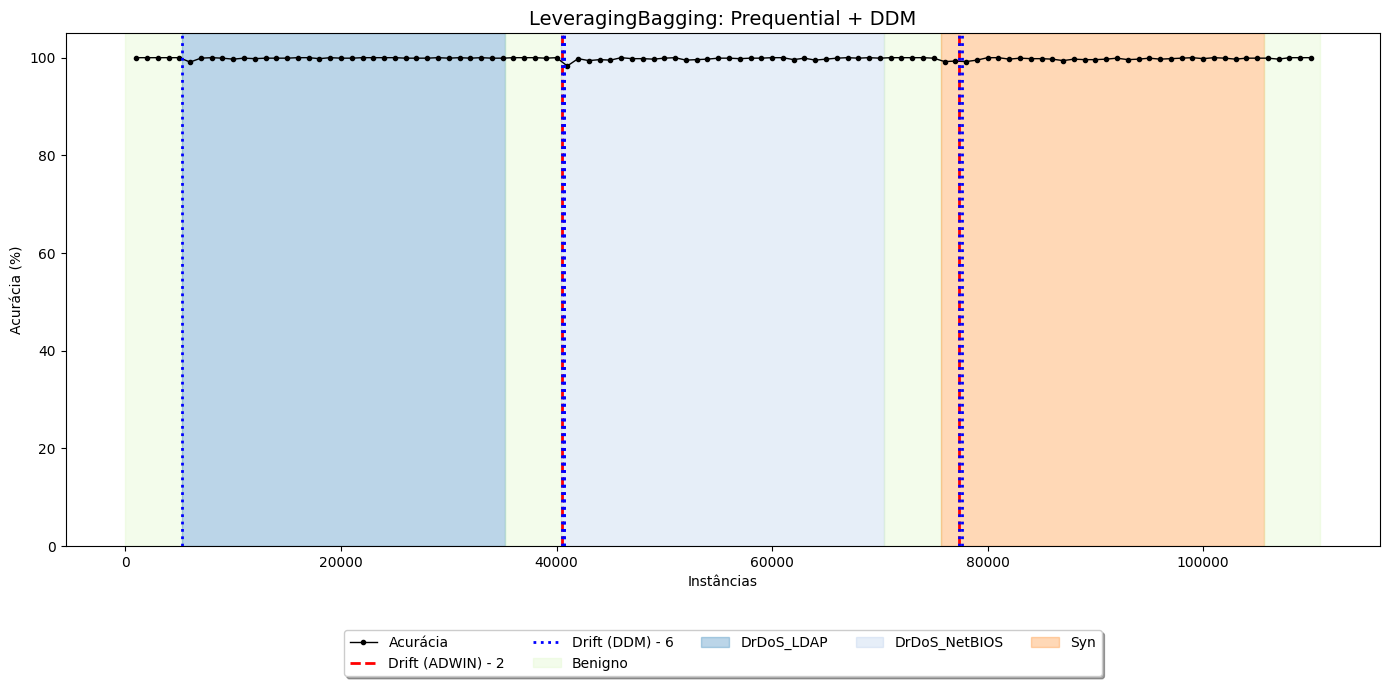

======================= HoeffdingAdaptiveTree =======================
       Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
   DrDoS_LDAP         5215  90.00%          141 0.000895
DrDoS_NetBIOS        40430  87.00%          140 0.002325
          Syn        75645  92.00%          106 0.001899


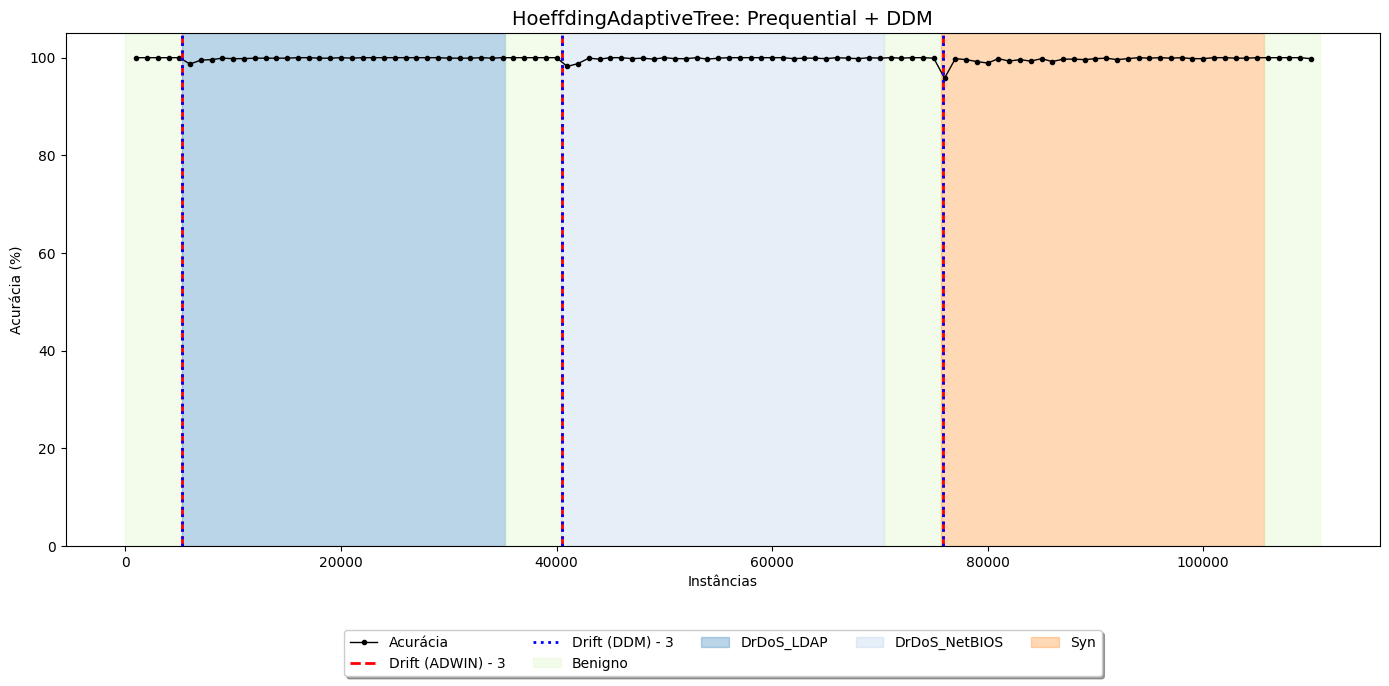

======================= AdaptiveRandomForest =======================
       Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
   DrDoS_LDAP         5215  93.00%          104 0.002103
DrDoS_NetBIOS        40430  92.00%          108 0.002189
          Syn        75645  95.00%           99 0.002366


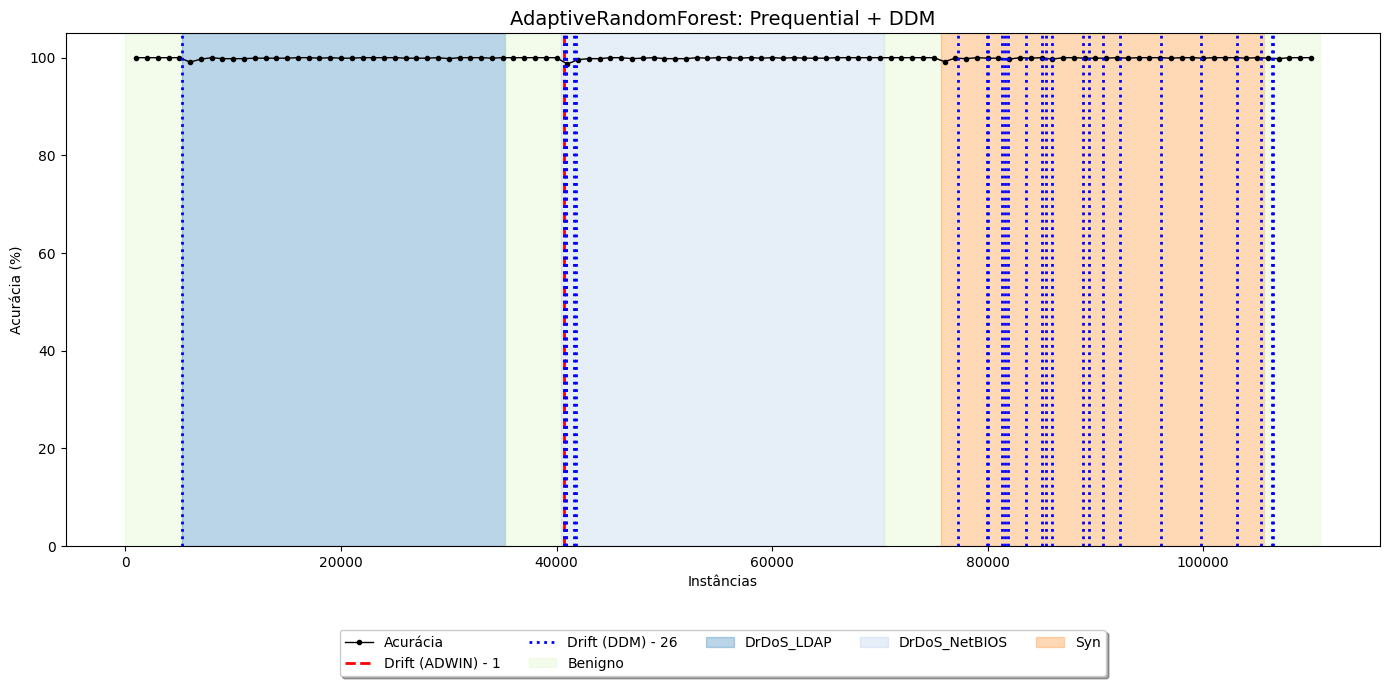

======================= HoeffdingTree =======================
       Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
   DrDoS_LDAP         5215  94.00%          100 0.001561
DrDoS_NetBIOS        40430  91.00%          108 0.002771
          Syn        75645  91.00%          108 0.002021


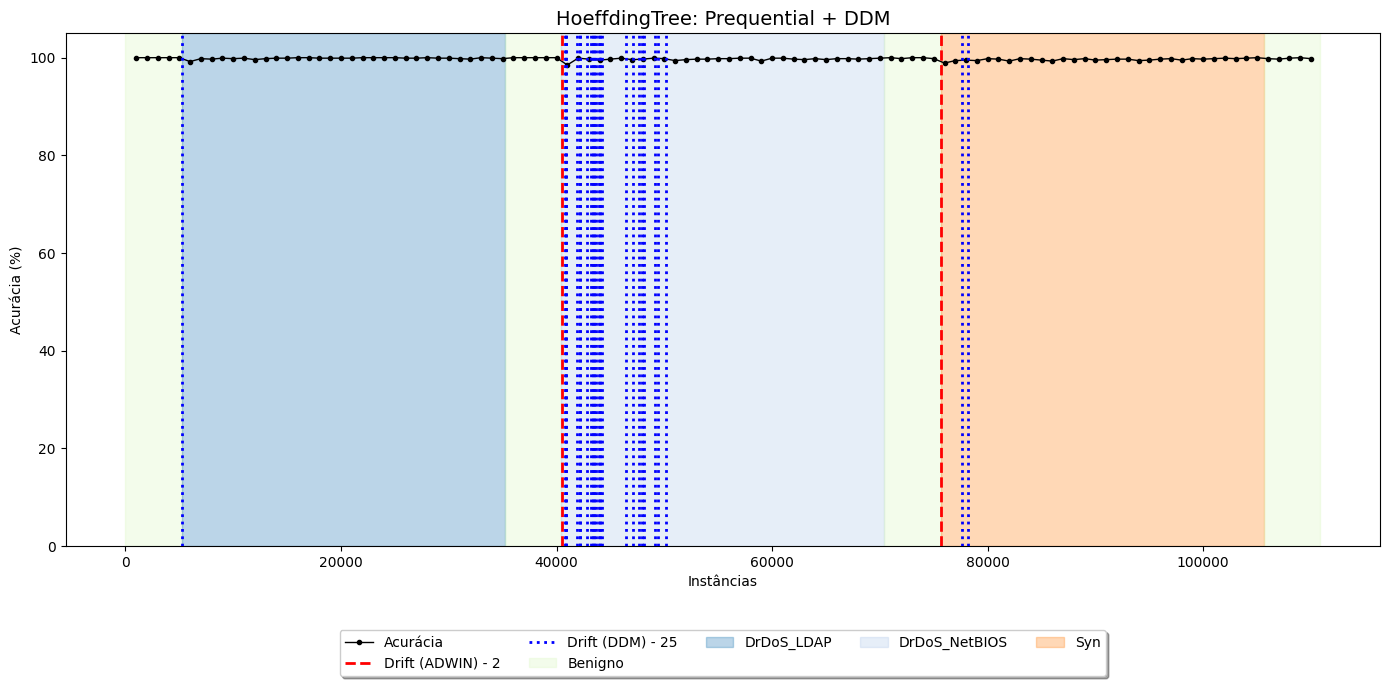

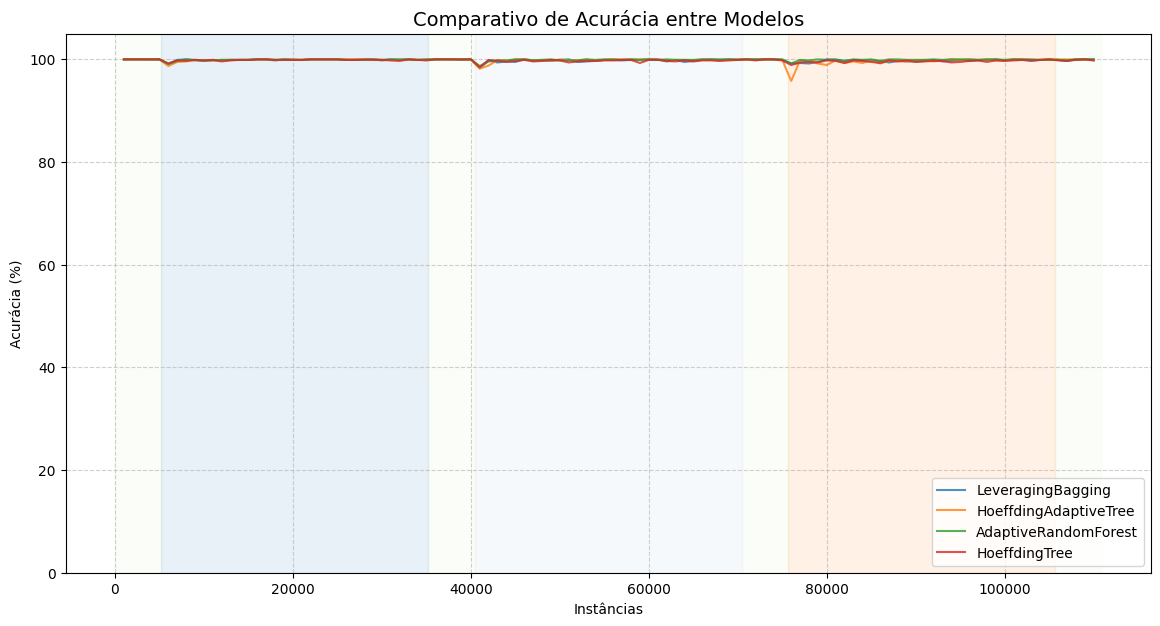

In [19]:
print(f"Carregando Stream: {FILE_1}")
df_raw = pd.read_csv(FILE_1)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_1, le_global = criar_stream(
    df=df_raw, 
    target_label_col="Label" 
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_1.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM() 
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = [] 

instance_count_history = [] 
count = 0

cenario_1.restart() 

while cenario_1.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_1.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            mean_acc = 1.0 - np.mean(state["window_errors"])
            state["results_accuracy"].append(mean_acc * 100)
            state["window_errors"].clear()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(instance_count_history, state['results_accuracy'], 'o-', 
             label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--', 
               linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':', 
               linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    ax.set_ylabel('Acurácia (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de Acurácia entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário 2

In [20]:
FILE_2 = r'datasets\CICDDoS2019\Experimentos\Exp_2\stream_Memoria.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_2\metadata_Memoria.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_2\stream_Memoria.csv
Features: 85
Classes identificadas: ['BENIGN' 'DrDoS_MSSQL' 'DrDoS_UDP']
======================= LeveragingBagging =======================
     Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
  DrDoS_UDP         5215  93.00%          104 0.002432
DrDoS_MSSQL        40430  67.00%          148 0.004333
  DrDoS_UDP        75645  83.00%          123 0.006003


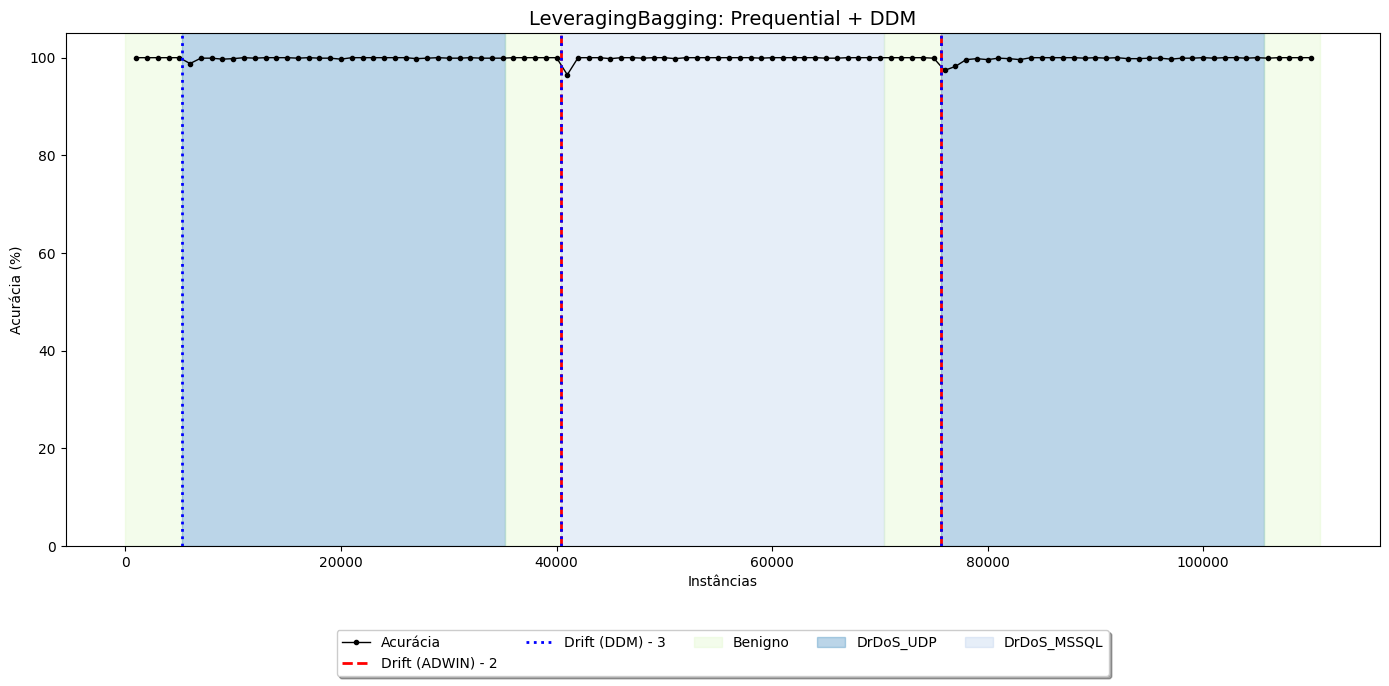

======================= HoeffdingAdaptiveTree =======================
     Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
  DrDoS_UDP         5215  89.00%          140 0.001680
DrDoS_MSSQL        40430  62.00%          305 0.003734
  DrDoS_UDP        75645  77.00%          159 0.004879


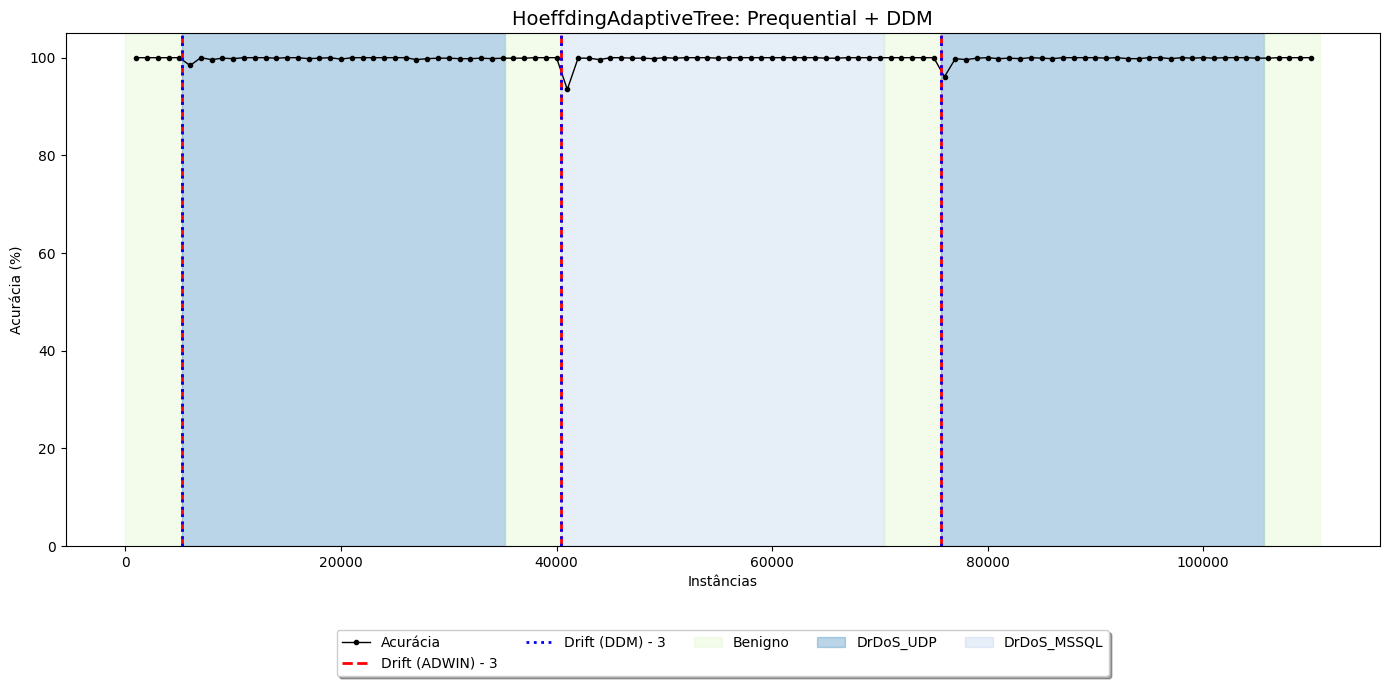

======================= AdaptiveRandomForest =======================
     Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
  DrDoS_UDP         5215  93.00%          104 0.002432
DrDoS_MSSQL        40430  85.00%          114 0.005529
  DrDoS_UDP        75645  87.00%          115 0.005216


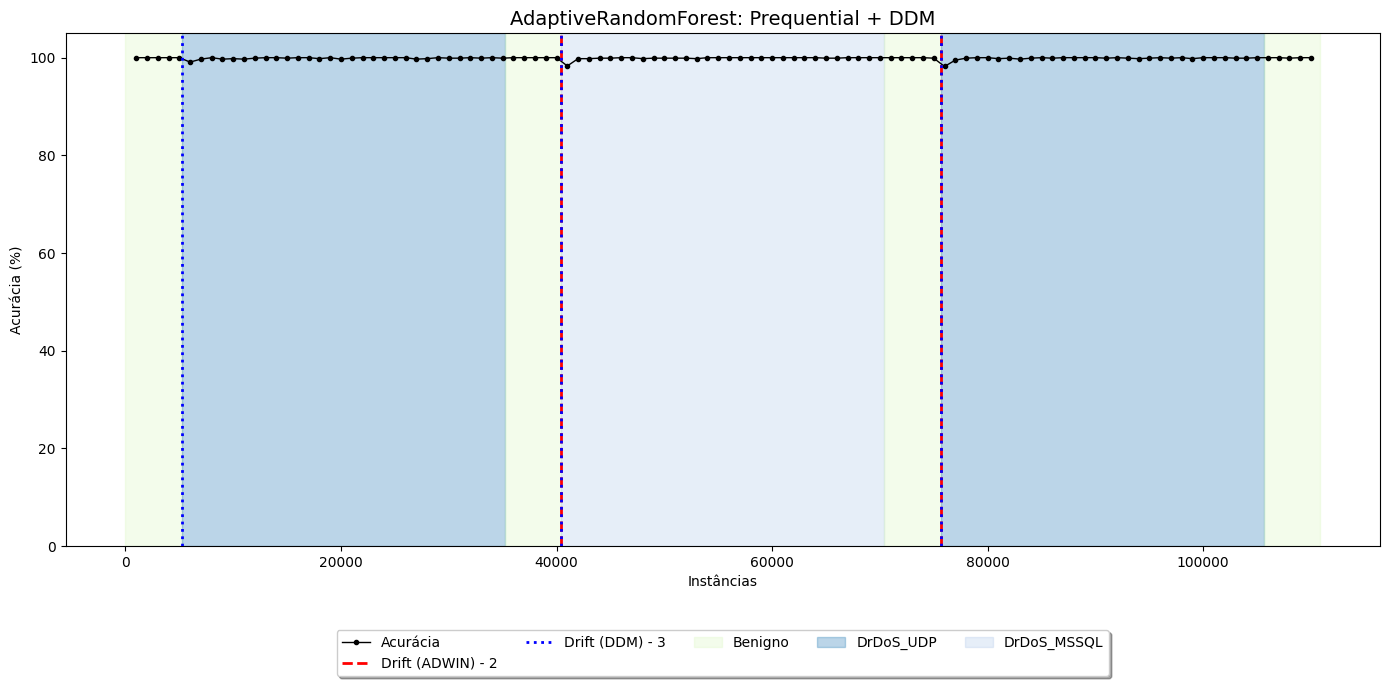

======================= HoeffdingTree =======================
     Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
  DrDoS_UDP         5215  93.00%          104 0.002432
DrDoS_MSSQL        40430  39.00%          261 0.000249
  DrDoS_UDP        75645  84.00%          264 0.003603


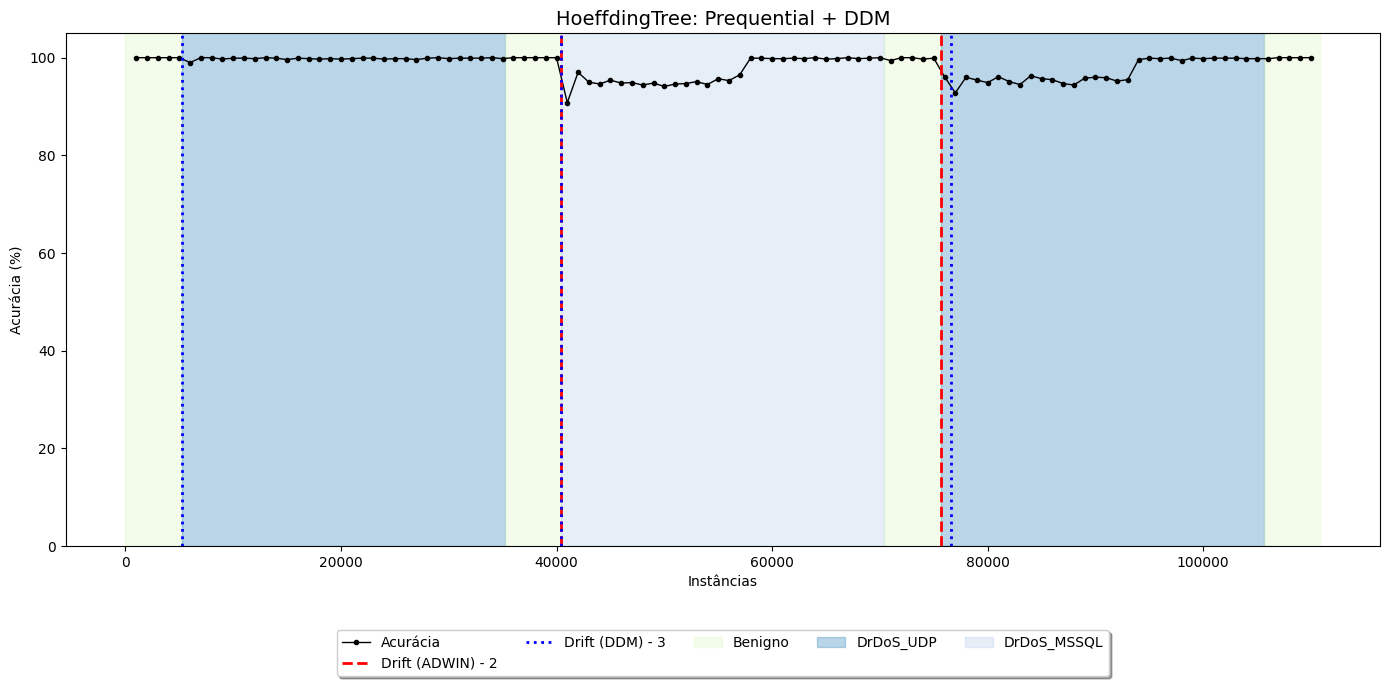

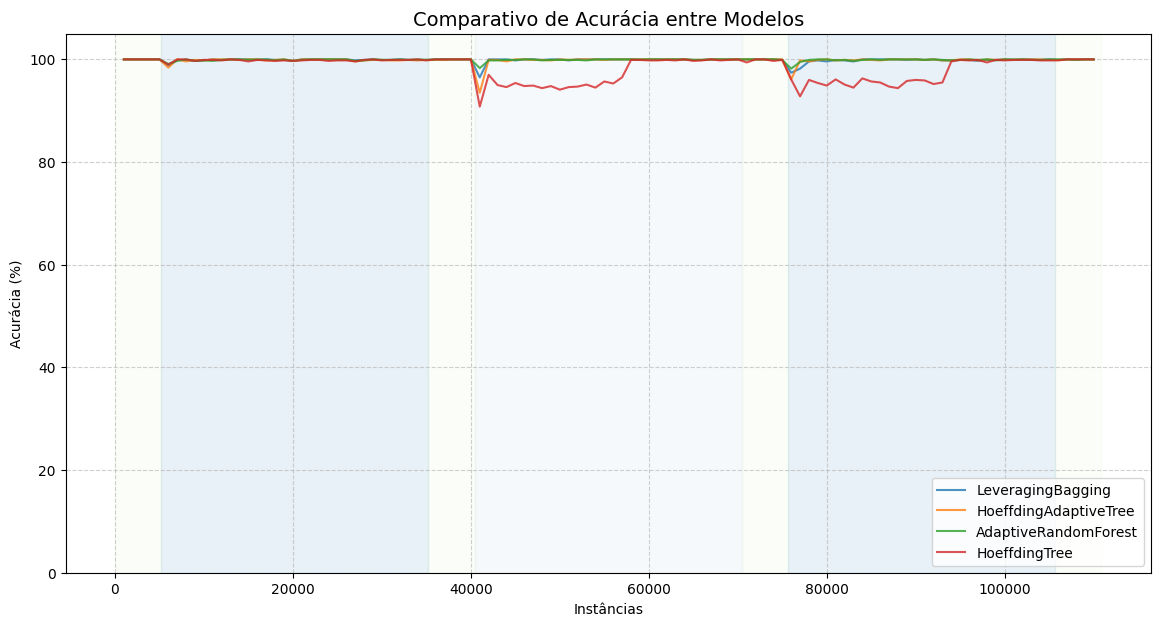

In [21]:
print(f"Carregando Stream: {FILE_2}")
df_raw = pd.read_csv(FILE_2)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_1, le_global = criar_stream(
    df=df_raw, 
    target_label_col="Label" 
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_1.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM() 
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = [] 

instance_count_history = [] 
count = 0

cenario_1.restart() 

while cenario_1.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_1.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            mean_acc = 1.0 - np.mean(state["window_errors"])
            state["results_accuracy"].append(mean_acc * 100)
            state["window_errors"].clear()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(instance_count_history, state['results_accuracy'], 'o-', 
             label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--', 
               linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':', 
               linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    ax.set_ylabel('Acurácia (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de Acurácia entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário 3

In [11]:
FILE_3 = r'datasets\CICDDoS2019\Experimentos\Exp_3\stream_Complexidade.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_3\metadata_Complexidade.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_3\stream_Complexidade.csv
Features: 85
Classes identificadas: ['BENIGN' 'DrDoS_DNS' 'DrDoS_NTP']
======================= LeveragingBagging =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      UDP         5215 100.00%           99 0.000000
DrDoS_NTP        22430  89.00%          126 0.002843
DrDoS_DNS        57645  70.00%          145 0.004914


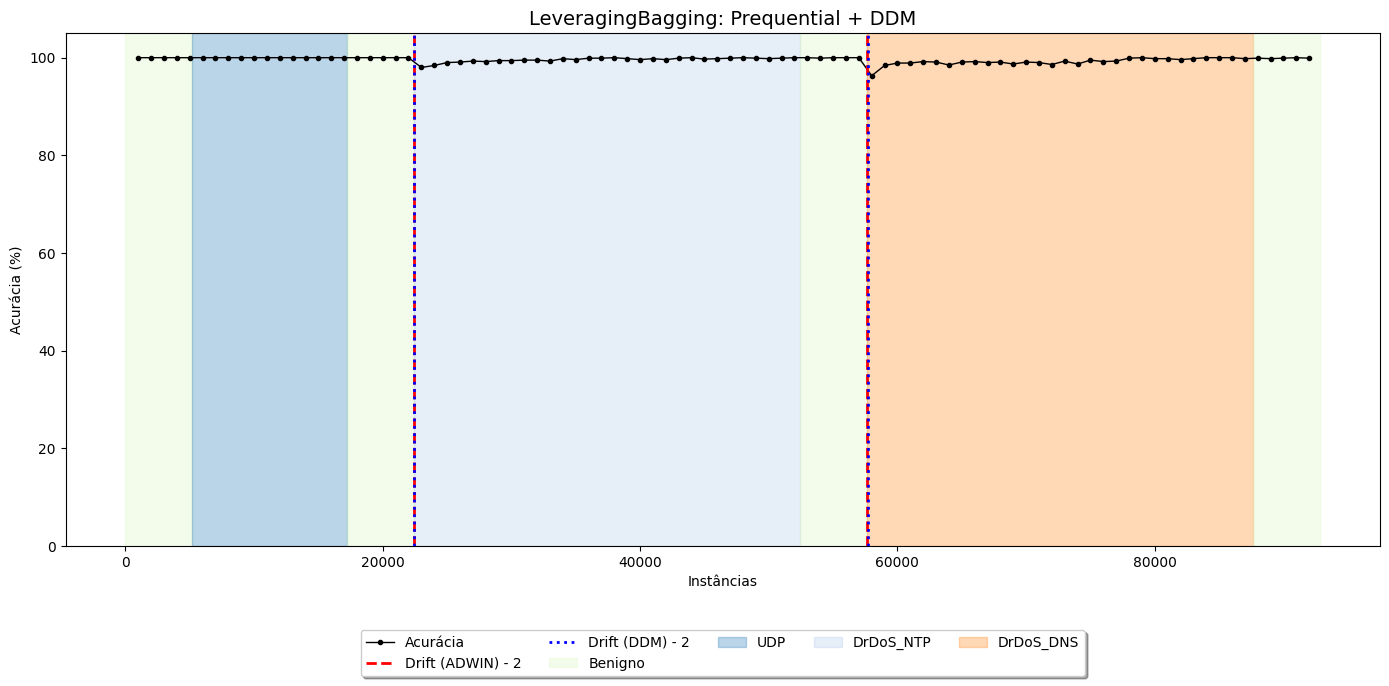

======================= HoeffdingAdaptiveTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      UDP         5215 100.00%           99 0.000000
DrDoS_NTP        22430  90.00%          193 0.001719
DrDoS_DNS        57645  47.00%          243 0.000846


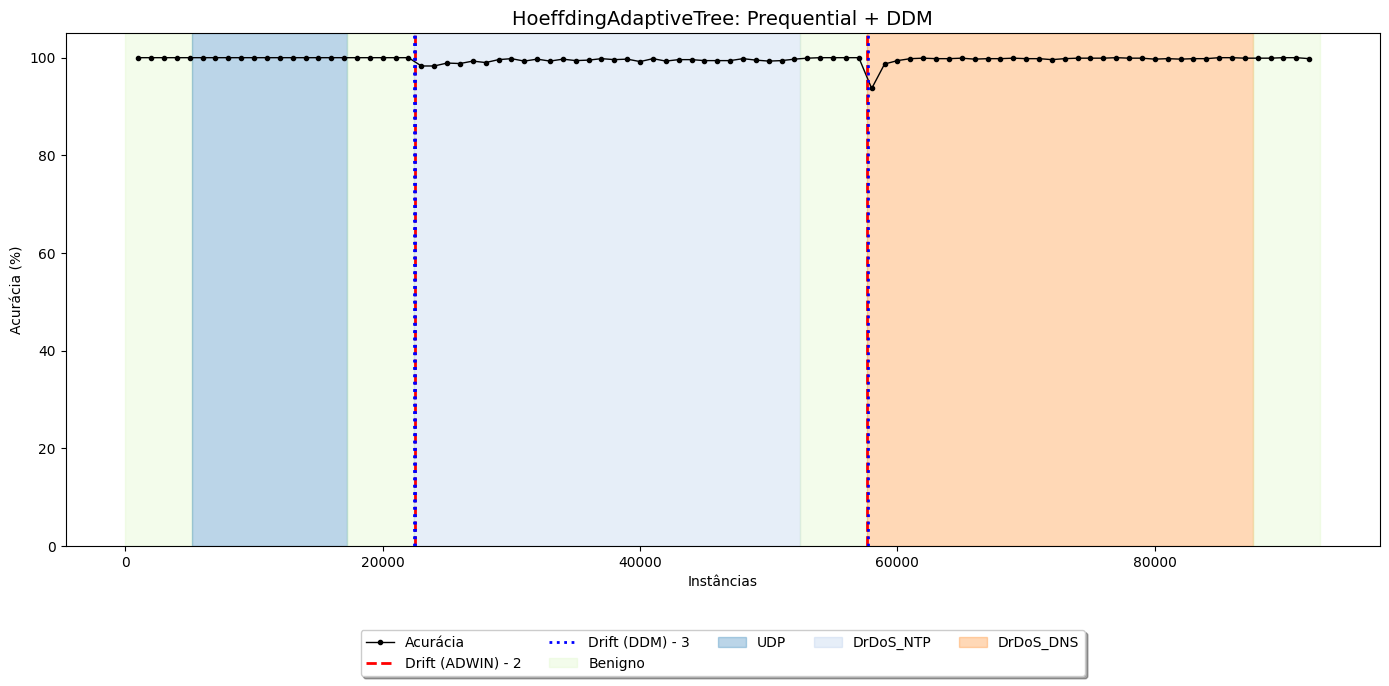

======================= AdaptiveRandomForest =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      UDP         5215 100.00%           99 0.000000
DrDoS_NTP        22430  91.00%          114 0.002322
DrDoS_DNS        57645  90.00%          107 0.004053


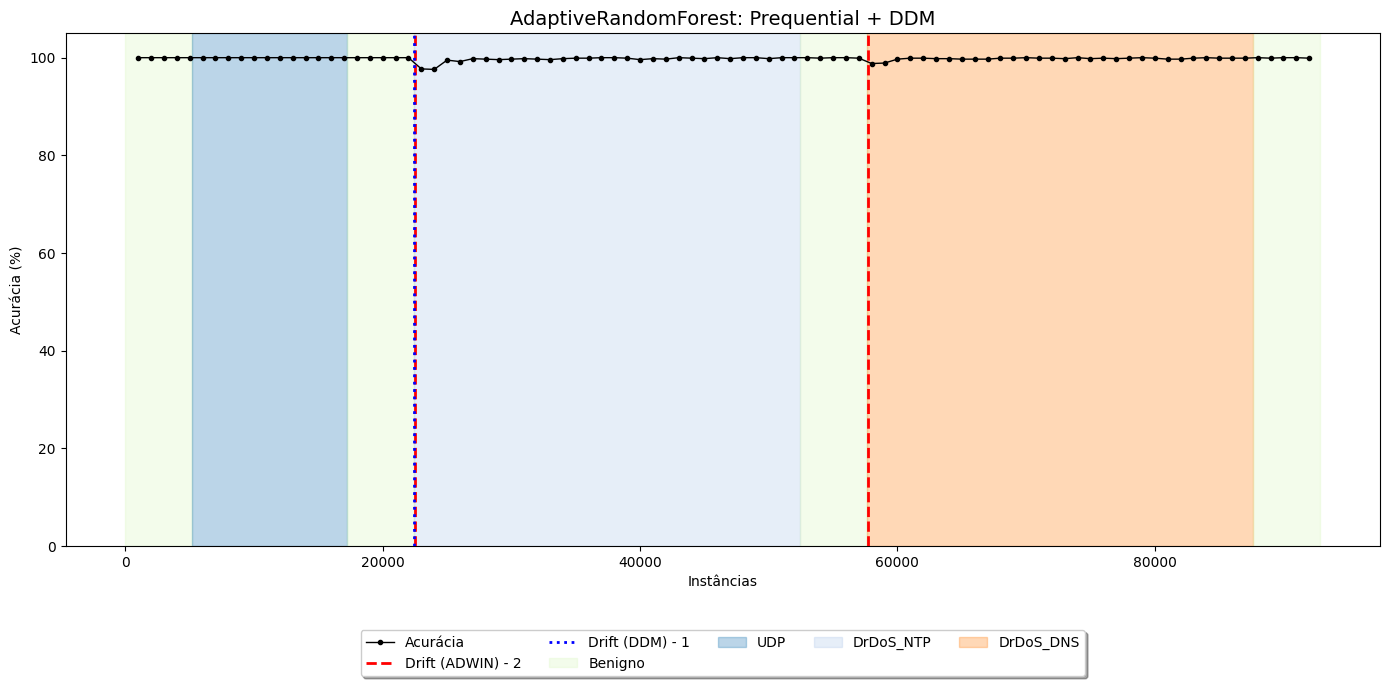

======================= HoeffdingTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      UDP         5215 100.00%           99 0.000000
DrDoS_NTP        22430  94.00%          100 0.001928
DrDoS_DNS        57645  44.00%          233 0.000604


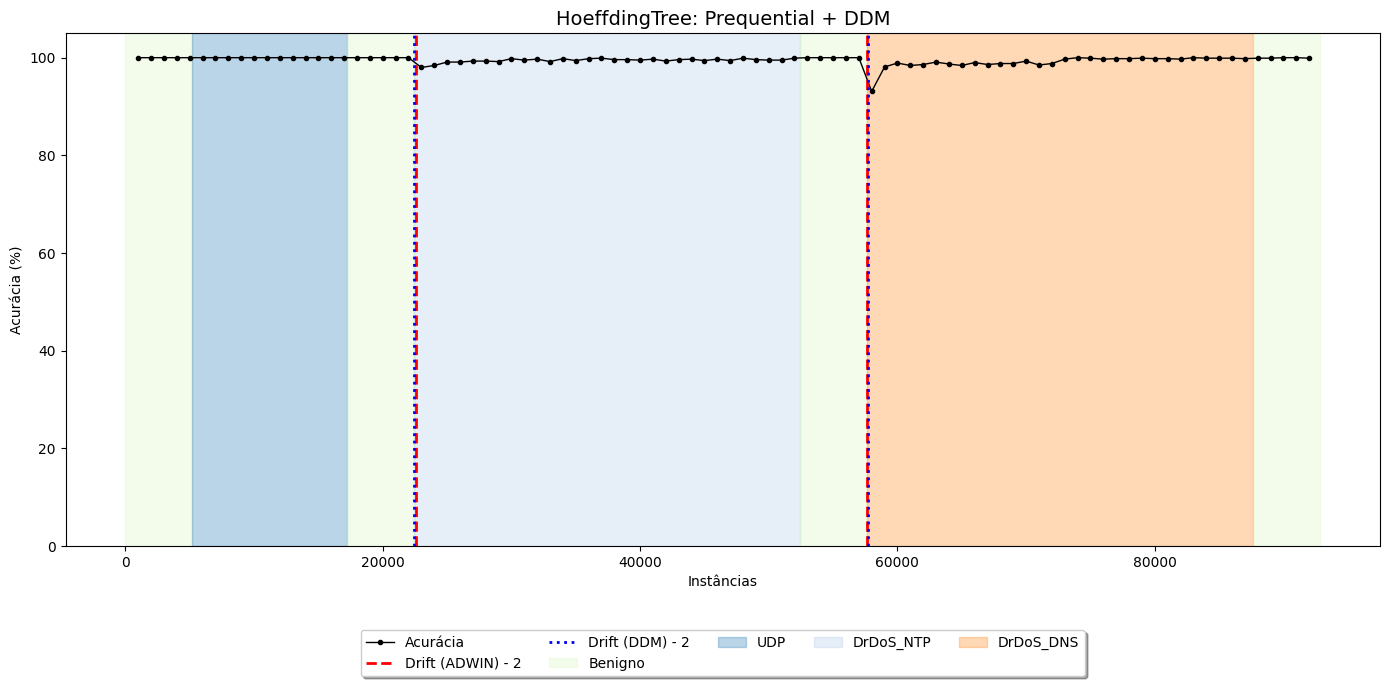

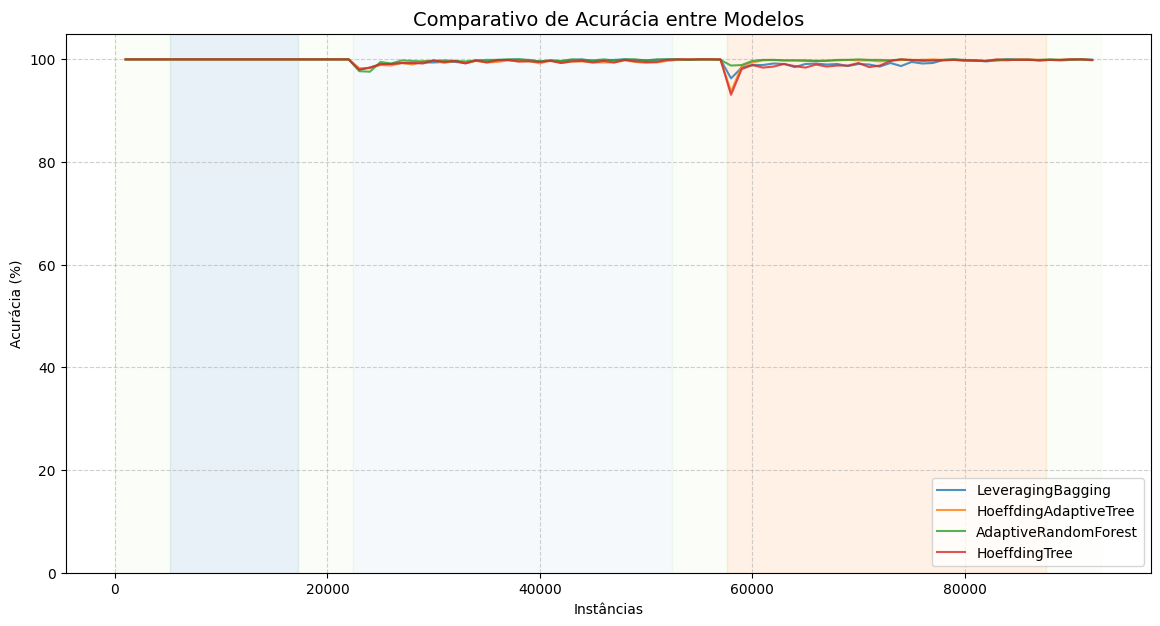

In [12]:
print(f"Carregando Stream: {FILE_3}")
df_raw = pd.read_csv(FILE_3)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_1, le_global = criar_stream(
    df=df_raw, 
    target_label_col="Label" 
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_1.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM() 
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = [] 

instance_count_history = [] 
count = 0

cenario_1.restart() 

while cenario_1.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_1.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            mean_acc = 1.0 - np.mean(state["window_errors"])
            state["results_accuracy"].append(mean_acc * 100)
            state["window_errors"].clear()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(instance_count_history, state['results_accuracy'], 'o-', 
             label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--', 
               linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':', 
               linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    ax.set_ylabel('Acurácia (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de Acurácia entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário A

In [14]:
FILE_A = r'datasets\CICDDoS2019\Experimentos\Exp_A\stream_Heterogeneidade_A.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_A\metadata_Heterogeneidade_A.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_A\stream_Heterogeneidade_A.csv
Features: 85
Classes identificadas: ['BENIGN' 'DrDoS_NTP' 'Syn']
======================= LeveragingBagging =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%     Slope
      Syn         2954  89.00%          141  0.000390
   BENING        32954 100.00%           99  0.000000
DrDoS_NTP        44954  91.00%          108  0.002832
      Syn        77908  98.00%           99 -0.000062


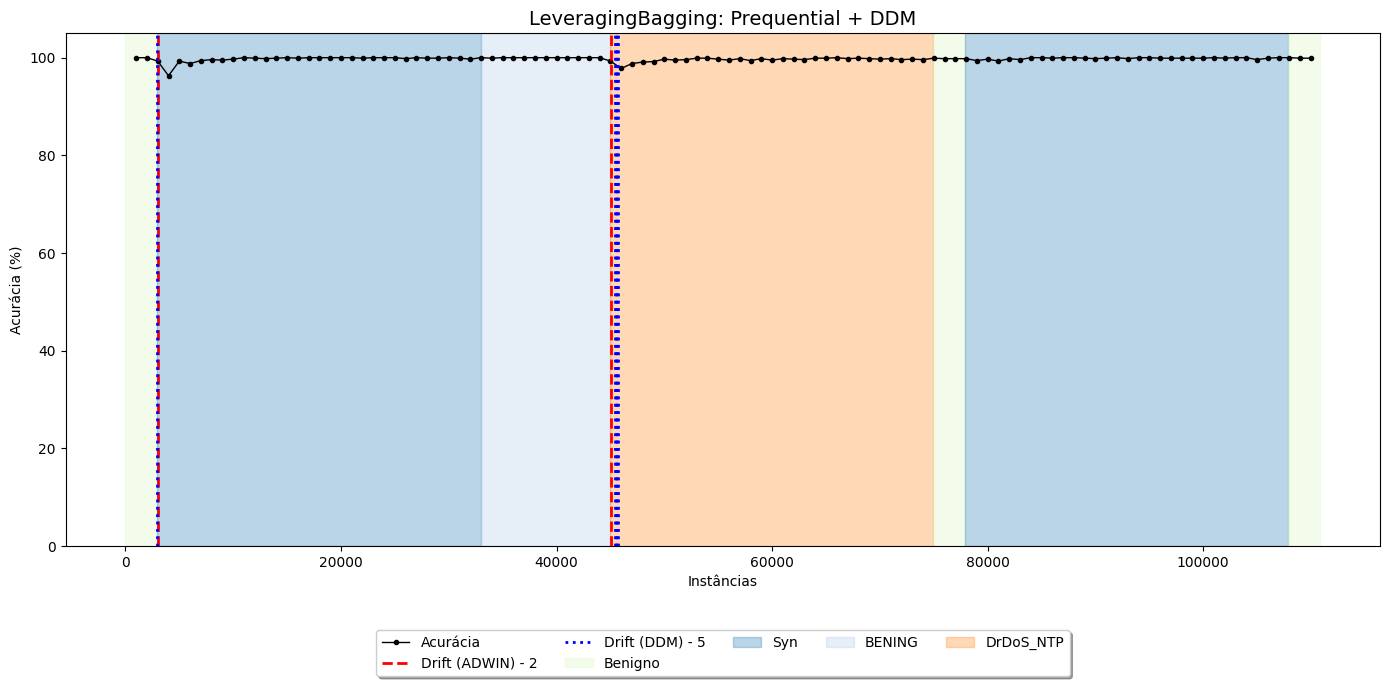

======================= HoeffdingAdaptiveTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%     Slope
      Syn         2954  93.00%          112  0.000947
   BENING        32954 100.00%           99  0.000000
DrDoS_NTP        44954  93.00%          104  0.001897
      Syn        77908  57.00%          246 -0.001652


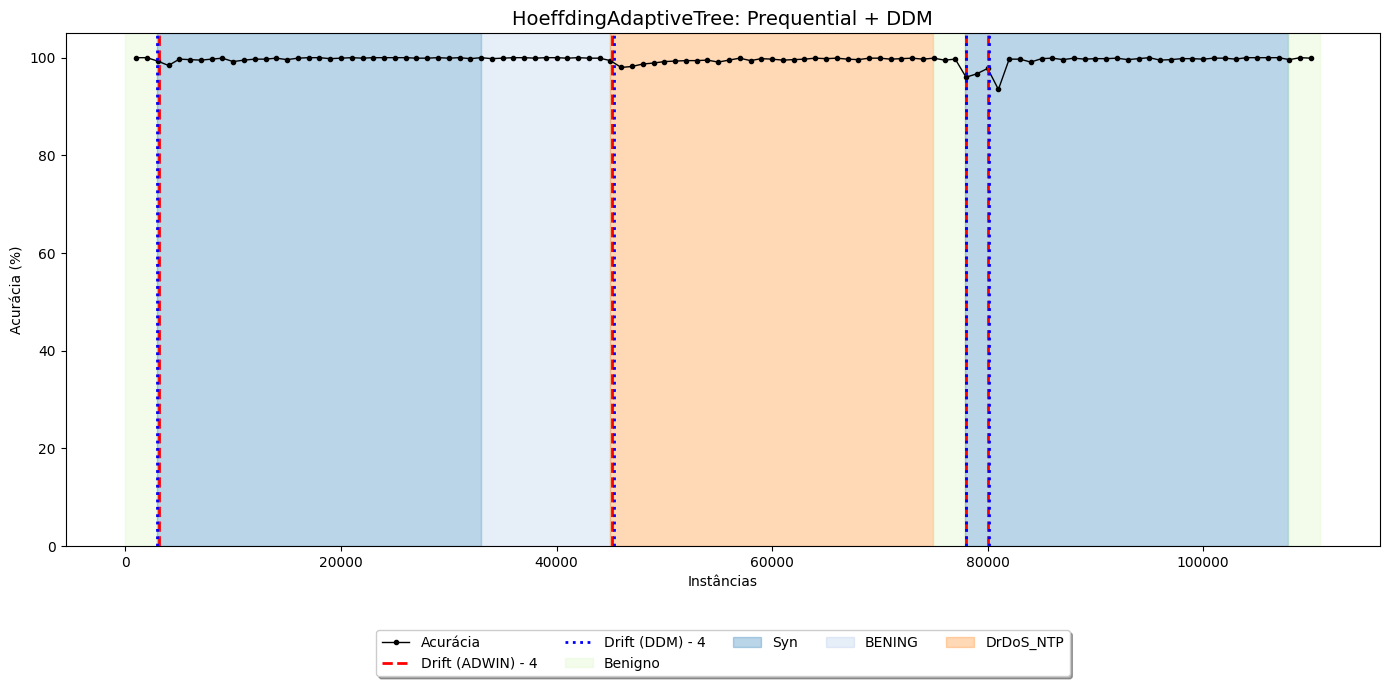

======================= AdaptiveRandomForest =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      Syn         2954  89.00%          132 0.000951
   BENING        32954 100.00%           99 0.000000
DrDoS_NTP        44954  93.00%          104 0.001897
      Syn        77908  97.00%           99 0.001202


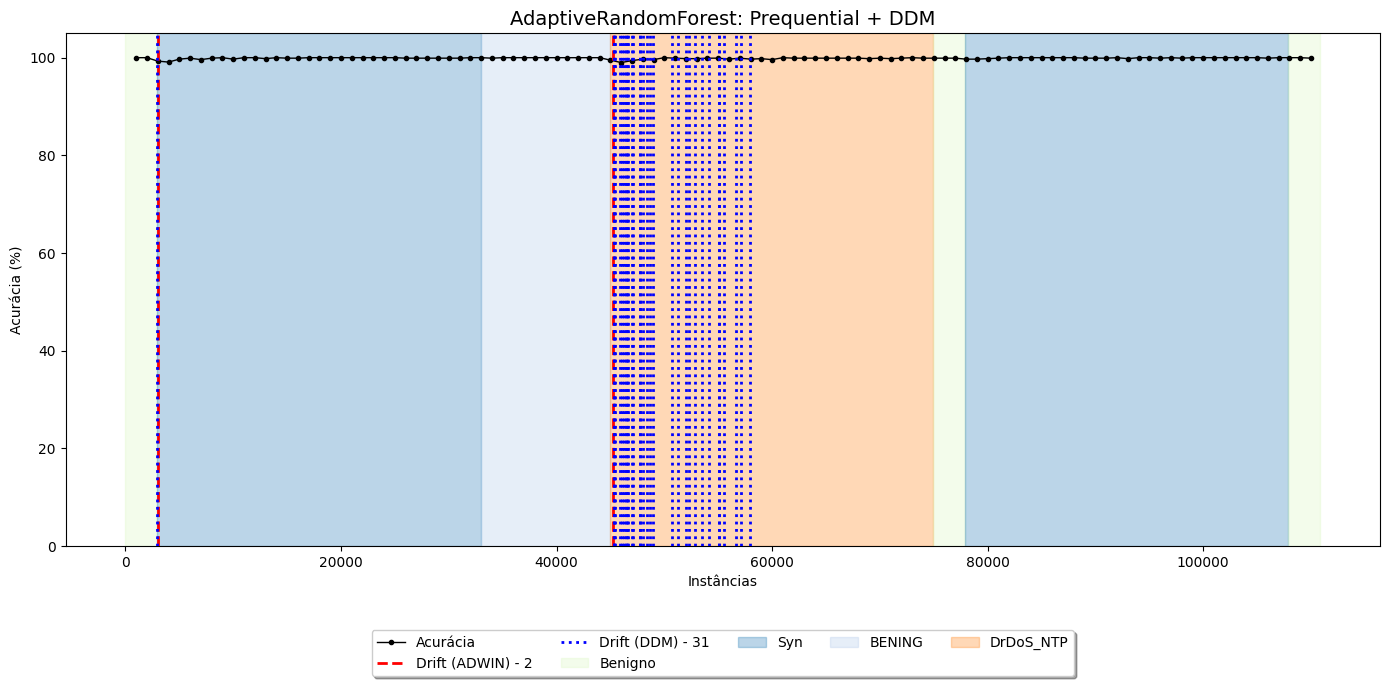

======================= HoeffdingTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
      Syn         2954  93.00%          112 0.000947
   BENING        32954 100.00%           99 0.000000
DrDoS_NTP        44954  83.00%          206 0.002657
      Syn        77908  97.00%           99 0.000544


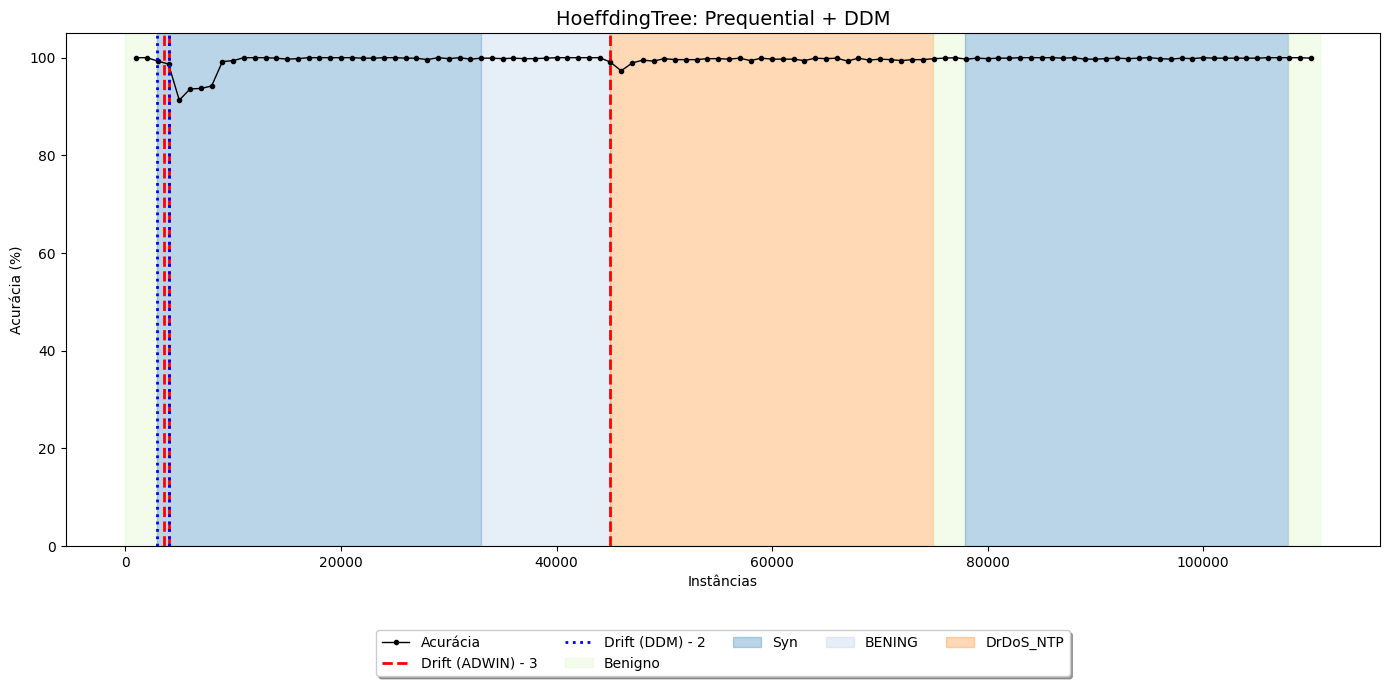

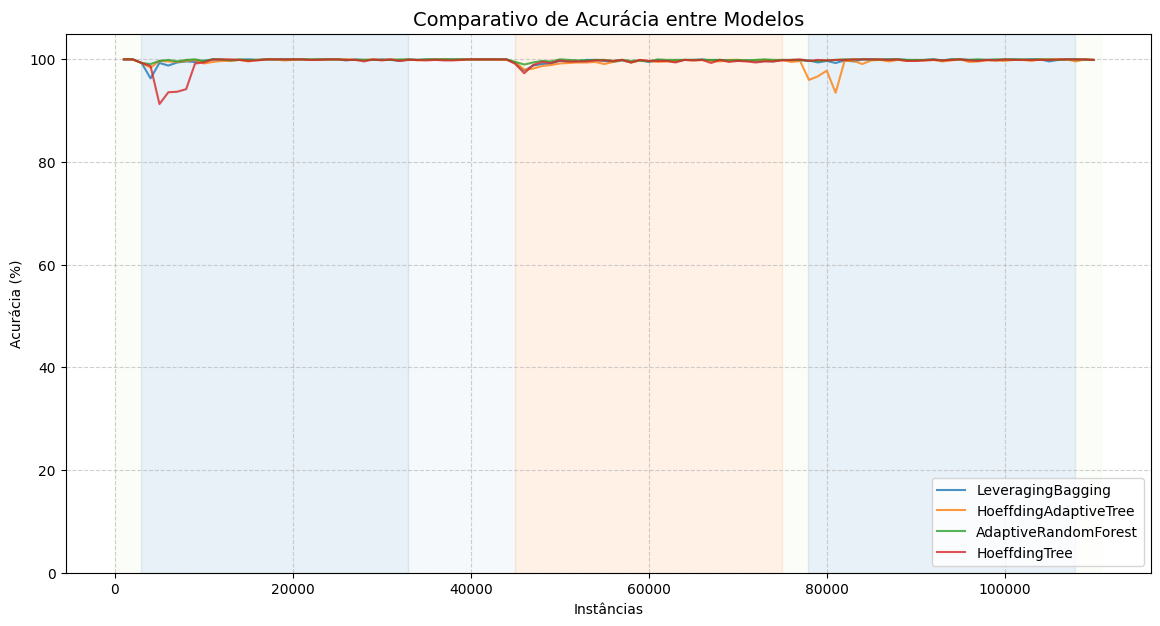

In [ ]:
print("Sequencia do cenário A: [BENIGN -> Syn -> BENIGN -> DrDoS_NTP -> BENIGN -> Syn -> BENIGN]")
print(f"Carregando Stream: {FILE_A}")
df_raw = pd.read_csv(FILE_A)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_A, le_global = criar_stream(
    df=df_raw,
    target_label_col="Label"
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_A.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM()
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = []

instance_count_history = []
count = 0

cenario_A.restart()

while cenario_A.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_A.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            mean_acc = 1.0 - np.mean(state["window_errors"])
            state["results_accuracy"].append(mean_acc * 100)
            state["window_errors"].clear()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(instance_count_history, state['results_accuracy'], 'o-',
            label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--',
            linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':',
            linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    ax.set_ylabel('Acurácia (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de Acurácia entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

## Cenário B

In [16]:
FILE_B = r'datasets\CICDDoS2019\Experimentos\Exp_B\stream_Heterogeneidade_B.csv'
META_FILE = r'datasets\CICDDoS2019\Experimentos\Exp_B\metadata_Heterogeneidade_B.csv'
WINDOW_SIZE = 1000
MAX_INSTANCES = 167828

Carregando Stream: datasets\CICDDoS2019\Experimentos\Exp_B\stream_Heterogeneidade_B.csv
Features: 85
Classes identificadas: ['BENIGN' 'DrDoS_NTP' 'Syn']
======================= LeveragingBagging =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_NTP         5215  92.00%          107 0.002648
      Syn        40430  94.00%          100 0.002054
DrDoS_NTP        75645 100.00%           99 0.000000


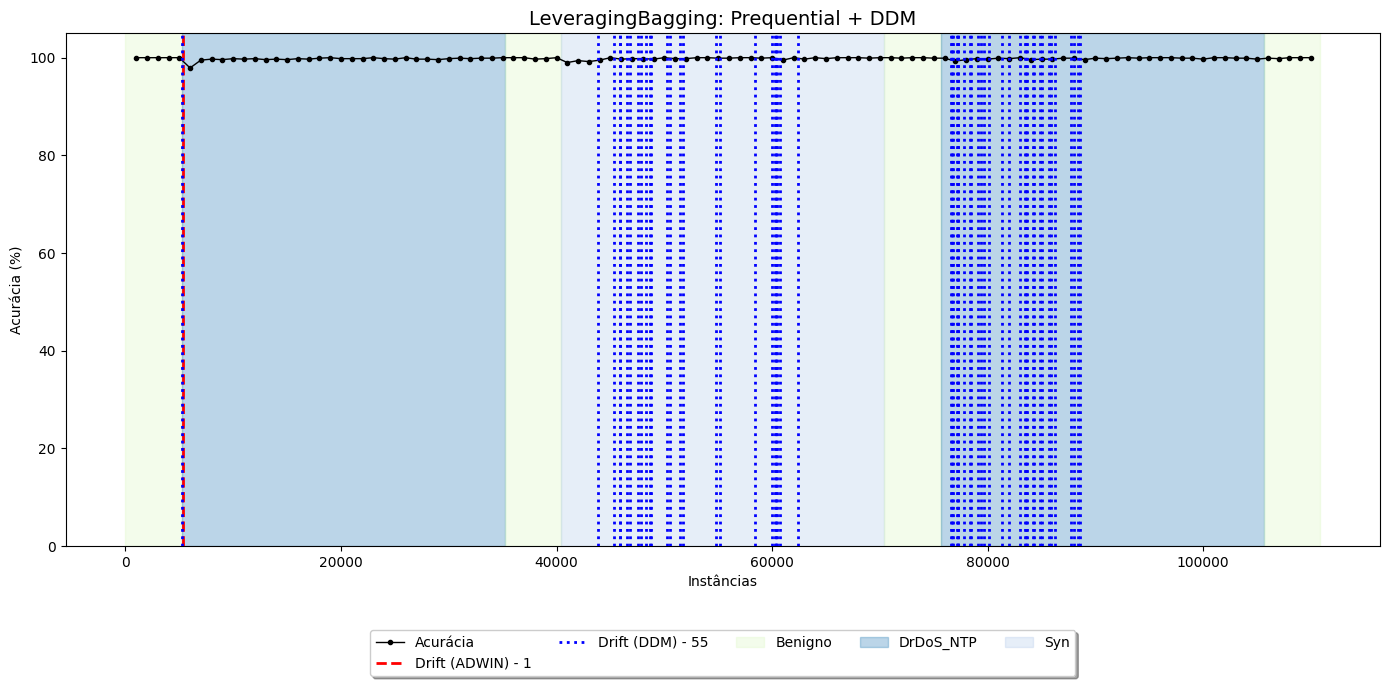

======================= HoeffdingAdaptiveTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_NTP         5215  83.00%          171 0.001067
      Syn        40430  92.00%          114 0.001836
DrDoS_NTP        75645 100.00%           99 0.000000


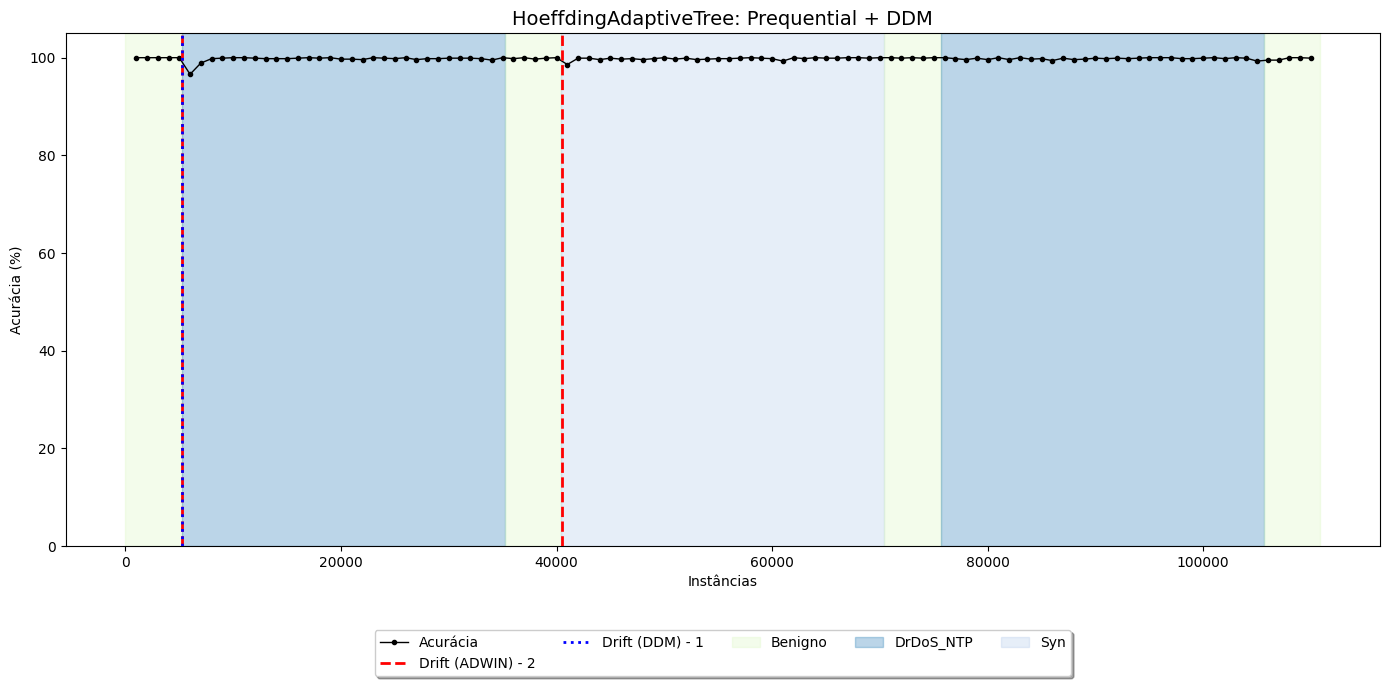

======================= AdaptiveRandomForest =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_NTP         5215  89.00%          123 0.001891
      Syn        40430  93.00%          104 0.001939
DrDoS_NTP        75645  98.00%           99 0.000408


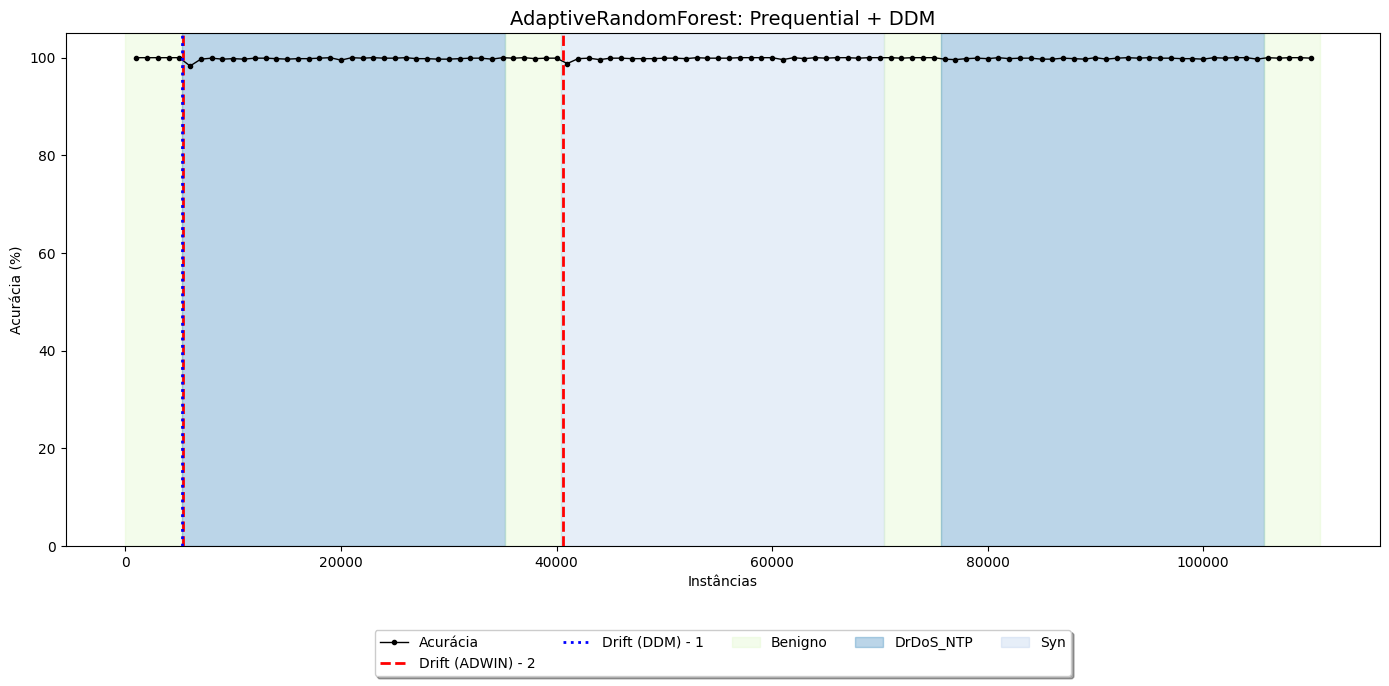

======================= HoeffdingTree =======================
   Evento  Inicio_Real Acc_@_N  Time_to_95%    Slope
DrDoS_NTP         5215  94.00%          100 0.002233
      Syn        40430  93.00%          104 0.001955
DrDoS_NTP        75645 100.00%           99 0.000000


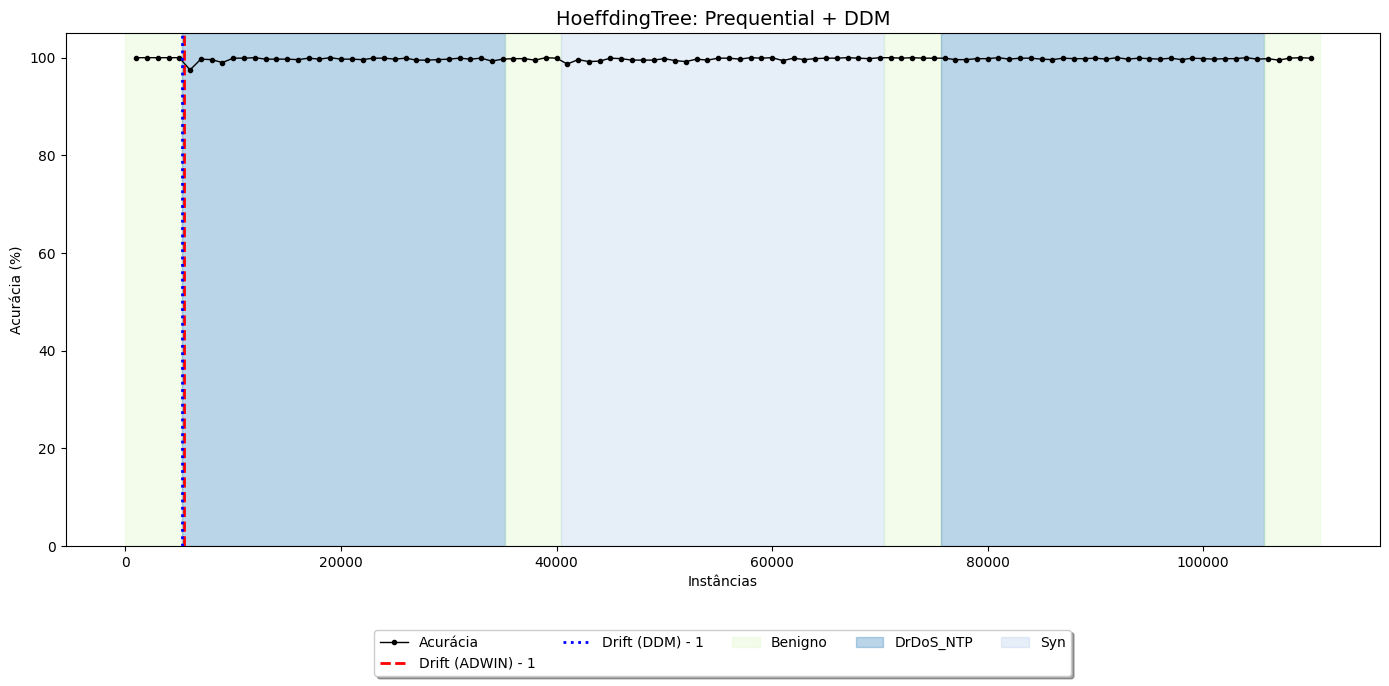

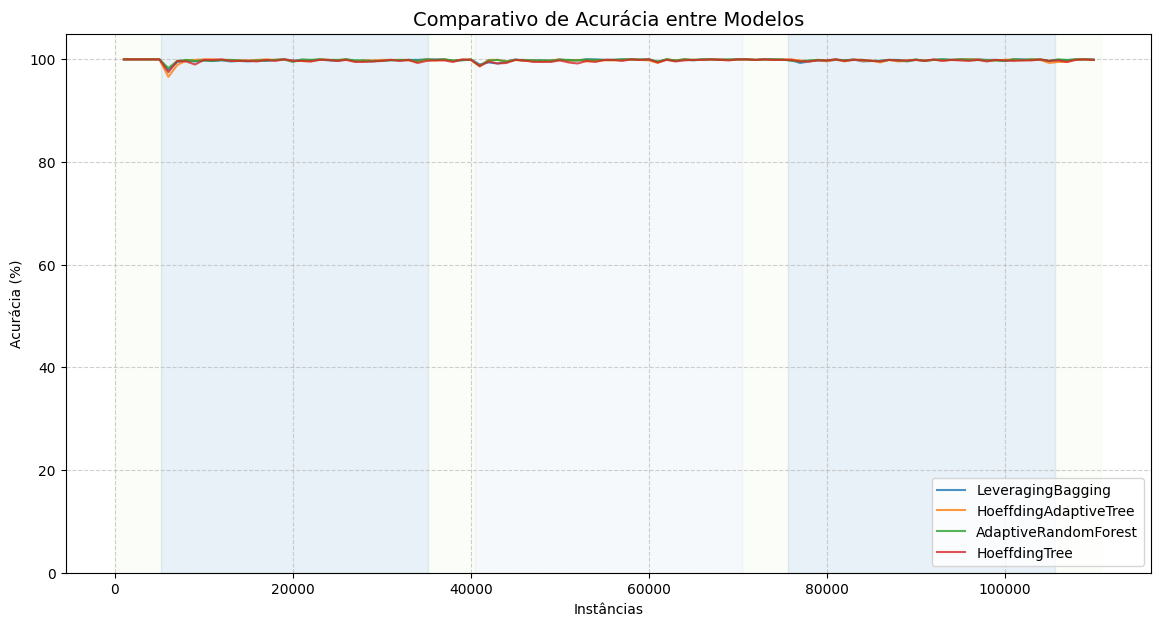

In [17]:
print(f"Carregando Stream: {FILE_B}")
df_raw = pd.read_csv(FILE_B)
df_meta = pd.read_csv(META_FILE)

# Usar todas as features (sem otimização de correlação)
cenario_B, le_global = criar_stream(
    df=df_raw,
    target_label_col="Label"
)

print(f"Features: {df_raw.shape[1]}")
print(f"Classes identificadas: {le_global.classes_}")

rotulos_unicos = df_meta['Evento'].apply(extrair_rotulo_dinamico).unique()
paleta = plt.get_cmap('tab20')
mapa_cores = {}

idx_cor = 0
for rotulo in rotulos_unicos:
    if rotulo == "Benigno":
        mapa_cores[rotulo] = '#d9f7be'
    else:
        mapa_cores[rotulo] = paleta(idx_cor)
        idx_cor += 1

models_to_test = get_models(cenario_B.schema, WINDOW_SIZE)

for m_name in models_to_test:
    models_to_test[m_name]["drift_ddm"] = DDM()
    models_to_test[m_name]["results_drift_ddm"] = []
    models_to_test[m_name]["prediction_history"] = []

instance_count_history = []
count = 0

cenario_B.restart()

while cenario_B.has_more_instances() and count < MAX_INSTANCES:
    instance = cenario_B.next_instance()
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        pred_val = prediction[0] if isinstance(prediction, (list, np.ndarray)) else prediction
        
        state["evaluator"].update(instance.y_index, pred_val)
        
        is_correct = (pred_val == instance.y_index)
        error = 0 if is_correct else 1
        
        state["prediction_history"].append(1 if is_correct else 0)
        state["window_errors"].append(error)
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        state["drift_ddm"].add_element(error) 
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        model.train(instance)
        
        if is_window_boundary:
            mean_acc = 1.0 - np.mean(state["window_errors"])
            state["results_accuracy"].append(mean_acc * 100)
            state["window_errors"].clear()
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

for model_name, state in models_to_test.items():
    print(f"======================= {model_name} =======================")
    
    df_metrics = calcular_metricas_avancadas(state['prediction_history'], df_meta)
    print(df_metrics.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(instance_count_history, state['results_accuracy'], 'o-', 
            label='Acurácia', color='black', linewidth=1, markersize=3, zorder=10)
    
    drift_adwin_count = len(state['results_drift_adwin'])
    drift_ddm_count = len(state['results_drift_ddm'])
    
    ax.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='red', linestyle='--', 
            linewidth=2, label=f'Drift (ADWIN) - {drift_adwin_count}', zorder=20)
    ax.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='blue', linestyle=':', 
            linewidth=2, label=f'Drift (DDM) - {drift_ddm_count}', zorder=20)

    legend_patches = []
    labels_added = set()
    for _, row in df_meta.iterrows():
        start, end = row['Inicio'], row['Fim']
        rotulo = extrair_rotulo_dinamico(row['Evento'])
        cor = mapa_cores.get(rotulo, 'gray')
        ax.axvspan(start, end, color=cor, alpha=0.3, zorder=0)
        if rotulo not in labels_added:
            legend_patches.append(mpatches.Patch(color=cor, alpha=0.3, label=rotulo))
            labels_added.add(rotulo)

    ax.set_title(f'{model_name}: Prequential + DDM', fontsize=14)
    ax.set_ylabel('Acurácia (%)')
    ax.set_xlabel('Instâncias')
    ax.set_ylim(0, 105)
    
    handles_lines, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles_lines + legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], '-', label=model_name, alpha=0.8)

for _, row in df_meta.iterrows():
    rotulo = extrair_rotulo_dinamico(row['Evento'])
    cor = mapa_cores.get(rotulo, 'gray')
    plt.axvspan(row['Inicio'], row['Fim'], color=cor, alpha=0.1, zorder=0)

plt.title('Comparativo de Acurácia entre Modelos', fontsize=14)
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()